# Equipos en Pokemon Showdown en octubre de 2019

El siguiente notebook contiene un análisis de una red representando equipos de Pokemon en el simulador de batallas Pokemon Showdown en el formato OU (Overused) en un nivel competitivo durante el mes de octubre de 2019. En una batalla Pokemon, cada uno de los dos participantes tiene un equipo con seis Pokemon, y el objetivo es el de reducir los puntos de vitalidad (HP) de todos los Pokemon del oponente a cero. Para esto, cada Pokemon tiene varios movimientos de los cuales uno solo se puede usar por turno, o bien se puede cambiar de Pokemon. Un equipo competitivo debe ser entonces creado teniendo en mente las debilidades y fortalezas de sus integrantes, por lo que es posible interpretar propiedades de una red de equipos en términos de estrategias en el metajuego.
<figure>
    <img src='pokemon_battle.jpeg' height='200' width='400'>
    <figcaption> Una batalla Pokemon. Las opciones fight y pokemon representan los movimientos del Pokemon en el campo y la opción de cambiar de Pokemon, respectivamente. Las barras verde representan el HP. Las opciones bag y run no están permitidas en batallas "serias", e.g. torneos.</figcaption>
</figure>
Una lista de tiers en videojuegos competitivos se refiere a un ordenamiento de personajes, objetos, etc. en términos, usualmente, de su frecuencia de uso y eficacia en las partidas. En Pokemon (generación 7, que incluye los juegos Pokemon Sol y Luna, así como Ultrasol y Ultraluna) se tienen, en orden de "peor" a "mejor", los tiers Untiered, PU, NU, RU, UU, OU y Uber. En cuál tier se encuentra un Pokemon depende directamente de su frecuencia de uso. También existen tiers "borderline" que aquí se consideran parte del tier subsecuente, e.g. UUBL se considerará como OU. En la red de este estudio los nodos serán únicamente Pokemon del tier OU (Overused), que representa, como su nombre los indica, a los Pokemon más usados (Uber es una lista de Pokemon baneados, que se consideran demasiado poderosos).

<p>
    
La información fue obtenida de https://www.smogon.com/stats/2019-01/chaos/gen7ou-1695.json. Este dataset contiene a todos los Pokemon, su porcentaje de uso en el simulador, los Pokemon con los que aparece así como la fracción de veces en las que aparece con ellos, entre otras cosas que aquí no se consideran. Como únicamente interesan Pokemon dentro del tier OU, se descargó además información relevante de los tiers mediante un web scraper escrito en Python de la página https://www.smogon.com/dex/sm/pokemon/.
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import seaborn as sns
sns.set()

import json

## Creación de la red dirigida

Se leen dos datasets. El primero está en csv y contiene información sobre los tiers y stats. El segundo está en json y contiene la información de la red.

In [2]:
pokedf = pd.read_csv('gen7Pokemon.csv')

pokedf = pokedf.set_index(pokedf['name']).drop('name',axis = 1)

Únicamente interesan los Pokemon que están en OU (y en UUBL, el cual se considera aquí como OU).

In [3]:
ou = pokedf[(pokedf['tier'] == 'OU') | (pokedf['tier'] == 'UUBL')]

In [4]:
with open('gen7ou-1695-2019-10.json','r') as archivo:
    datos = json.load(archivo)

Se genera la red. Esta será una red dirigida donde los nodos son Pokemon y hay un enlace del nodo i al j si j se encuentra en el equipo "más probable" de i, definido como el nodo i más los cinco Pokemon con el mayor porcentaje de uso (proba de aparecer en un equipo) dado i.

In [5]:
team_dict = {} #Contendrá los compañeros más comunes para cada pokemon
usage_dict = {} #Contendrá el porcentaje de uso

for pokemon, attr in datos['data'].items(): #attr = atributos
    if pokemon not in ou.index:
        continue
    teammates_Series = pd.Series() #Porque es necesario sortear por porcentaje de uso
    usage = attr['usage']
    for teammate, prob in attr['Teammates'].items():
        teammates_Series[teammate] = prob #El porcentaje por el que se sortea
        
    teammates = tuple(teammates_Series.sort_values(ascending = False).iloc[:5].index)
    team_dict[pokemon] = teammates
    usage_dict[pokemon] = usage
    
#team_dict

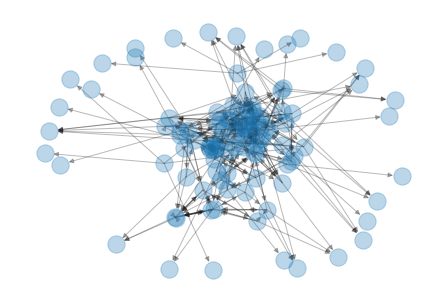

In [7]:
#Se genera la gráfica dirigida, donde los enlaces apuntan de un Pokemon a sus 5 compañeros más frecuentes

G = nx.DiGraph()
G.add_nodes_from(team_dict.keys())
for pokemon, team in team_dict.items():
    G.add_edges_from(zip([pokemon for i in team], team))
    
nx.draw(G, alpha = 0.3)

Se observa un 'núcleo' de Pokemon aparentemente interconectados, rodeado de varios nodos con un solo enlace de entrada.

In [8]:
df = pokedf.loc[list(G.nodes)] #Con este dataframe se trabajará de aquí en adelante

In [9]:
del pokedf

In [10]:
df['usage'] = pd.Series(usage_dict)
del usage_dict

## Componentes de la red y grados

Primero, se revisa que no haya nodos completamente desconectados.

In [11]:
flag = False
for pokemon, grado in dict(G.degree).items():
    if grado == 0:
        flag = True
        print(pokemon)
            
if flag == False:
    print('No hay nodos desconectados')

No hay nodos desconectados


Por lo que solo existe una componente en la red. Ahora se verán los Pokemon con grado de entrada o salida cero.

In [12]:
outDeg = dict(G.out_degree)

In [13]:
outDegSeries = pd.Series(dict(outDeg))
outDegSeries.rename_axis('name', inplace = True)

In [14]:
inDeg = dict(G.in_degree)

In [15]:
inDegSeries = pd.Series(dict(inDeg))

inDegSeries.rename_axis('name', inplace = True)

In [16]:
#Se imprimen los Pokemon con grado de entrada o salida cero, así como su tier

print('Out degree 0:')
for pokemon, grado in dict(G.out_degree).items():
    if grado == 0:
        tier = df.loc[pokemon]['tier']
        print(pokemon, tier)

print('\nIn degree 0:')
for pokemon, grado in dict(G.in_degree).items():
    if grado == 0:
        tier = df.loc[pokemon]['tier']
        print(pokemon, tier)


Out degree 0:
Ditto Untiered
Marowak-Alola RU
Hippowdon UU
Torkoal Untiered
Venusaur RU
Muk-Alola UU
Ribombee RU
Cresselia RU
Swampert UU
Bisharp UU
Quagsire UU
Slurpuff NUBL
Mamoswine UU
Cloyster RU
Infernape UU
Seismitoad NU
Hydreigon UU
Slowbro RU
Registeel RU
Mimikyu UU
Alomomola UU
Araquanid RU
Gastrodon PU
Shuckle Untiered
Galvantula RU
Mandibuzz RU
Mew UU
Hoopa RU
Empoleon UU
Shedinja Untiered

In degree 0:
Alakazam UUBL
Heracross-Mega UUBL
Latios UUBL
Latios-Mega UUBL
Azumarill OU
Xurkitree UUBL
Gyarados UUBL
Weavile UUBL
Porygon-Z UUBL
Gardevoir-Mega UUBL
Buzzwole UUBL
Ninetales-Alola UUBL
Diggersby UUBL
Gallade-Mega UUBL
Scolipede UUBL
Staraptor UUBL
Salamence UUBL


La interpretación de los Pokemon que aparecen con grado de salida cero (que, por cierto, no son de ou sino de otros tiers más bajos) es que únicamente aparecen junto con algún(os) otro(s) Pokemon como parte de una estrategia específica (e importante, dado que aparecen en el equipo más probable), pero por sí solos no sobreviven en el metajuego.

Por otro lado, que se tenga grado de entrada cero implica que no son utilizados en conjunción con otros Pokemon con frecuencia, i.e. hay pocas estrategias que los utilizan. Todos los Pokemon que aparecen con grado de entrada cero vienen de UUBL con la curiosa excepción de Azumarill. ¿Significa esto que Azumarill podría estar en peligro de caer a UU?

## Enlaces preferenciales

En esta sección se revisa si los Pokemon en UUBL y OU prefieren enlazarse con otros en su mismo tier.

In [19]:
#Se construye un dataframe con los tiers que aparecen en la red en sus columnas. El valor de la entrada
#(i,j) será el número de veces que un pokemon del tier j aparece enlazado con el pokemon i

#Las siguientes condiciones definen los tiers que se incluirán en el df
condUntiered = (df['tier'] == 'Untiered')
condPU = (df['tier'] == 'PU')
condNU = (df['tier'] == 'NU') | (df['tier'] == 'NUBL')
condRU = (df['tier'] == 'RU')
condUU = (df['tier'] == 'UU') | (df['tier'] == 'UUBL')
condOU = (df['tier'] == 'OU') | (df['tier'] == 'OUBL')

cond = condUntiered |  condPU | condNU | condRU | condUU | condOU

uubl = df[df['tier'] == 'UUBL'].index

neighborTiersUUBL = pd.DataFrame(columns = df[cond]['tier'].unique(), 
                             index = uubl)



for pokemon in uubl:
    in_edge = G.in_edges(pokemon)
    out_edge = G.out_edges(pokemon)
    if len(in_edge) > 0:
        in_neighbors = np.array(tuple(in_edge))[:,0] #Los vecinos conectados con un enlace de entrada
    else:
        in_neighbors = []
        
    if len(out_edge) > 0:
        out_neighbors = np.array(tuple(out_edge))[:,1] #Los vecinos conectados con un enlace de salida
    else:
        out_neighbors = []
    
    neighbors = set(in_neighbors).union(set(out_neighbors)) #Solo interesan los vecinos y no si sus 
    #enlaces son de entrada o de salida. Así también se evita que aparezca el mismo mon dos veces
    
    tier_counts = df.loc[list(neighbors)]['tier'].value_counts() #Número de veces que aparece cada tier
    #entre los vecinos del pokemon
    neighborTiersUUBL.loc[pokemon] = tier_counts    

In [20]:
totalUUBL = neighborTiersUUBL.sum().sum()
proporcionesTiersUUBL = neighborTiersUUBL.sum()/totalUUBL #El porcentaje de veces que aparece el tier
#en las conexiones de los UUBL
proporcionesTiersUUBL

OU          0.611111
UUBL        0.111111
Untiered    0.023810
RU          0.119048
UU          0.119048
NUBL        0.007937
NU          0.007937
PU          0.000000
dtype: float64

Entonces se observa que no, los UUBL no necesariamente prefieren conectarse entre ellos, aunque sí es importante recordar que hay más OU's que UUBL's (aproximadamente el doble):

In [23]:
df['tier'].value_counts()

OU          51
UUBL        24
UU          12
RU          11
Untiered     4
PU           1
NU           1
NUBL         1
Name: tier, dtype: int64

Ahora se hará lo mismo para OU:

In [21]:
#Se construye un dataframe con los tiers que aparecen en la red en sus columnas. El valor de la entrada
#(pokemon, tier) será el número de veces que un pokemon del tier aparece enlazado con el pokemon

condUntiered = (df['tier'] == 'Untiered')
condPU = (df['tier'] == 'PU')
condNU = (df['tier'] == 'NU') | (df['tier'] == 'NUBL')
condRU = (df['tier'] == 'RU')
condUU = (df['tier'] == 'UU') | (df['tier'] == 'UUBL')
condOU = (df['tier'] == 'OU') | (df['tier'] == 'OUBL')

cond = condUntiered |  condPU | condNU | condRU | condUU | condOU

ou = df[df['tier'] == 'OU'].index

neighborTiersOU = pd.DataFrame(columns = df[cond]['tier'].unique(), 
                             index = ou)



for pokemon in ou:
    in_edge = G.in_edges(pokemon)
    out_edge = G.out_edges(pokemon)
    
    if len(in_edge) > 0:
        in_neighbors = np.array(tuple(in_edge))[:,0] #Los vecinos conectados con un enlace de entrada
    else:
        in_neighbors = []
    if len(out_edge) > 0:
        out_neighbors = np.array(tuple(out_edge))[:,1] #Los vecinos conectados con un enlace de salida
    else:
        out_neighbors = []
    
    neighbors = set(in_neighbors).union(set(out_neighbors)) #Solo interesan los vecinos y no si sus 
    #enlaces son de entrada o de salida
    
    tier_counts = df.loc[list(neighbors)]['tier'].value_counts() #Número de veces que aparece cada tier
    neighborTiersOU.loc[pokemon] = tier_counts    

In [22]:
totalOU = neighborTiersOU.sum().sum()
proporcionesTiersOU = neighborTiersOU.sum()/totalOU

In [23]:
proporcionesTiersOU

OU          0.750630
UUBL        0.193955
Untiered    0.012594
RU          0.027708
UU          0.012594
NUBL        0.000000
NU          0.000000
PU          0.002519
dtype: float64

Los de OU tampoco prefieren conectarse entre ellos necesariamente, pero sí se observan diferencias en las proporciones de enlaces entre los OU y los UUBL. Las diferencias toman los siguientes valores:

In [24]:
proporcionesTiersOU - proporcionesTiersUUBL

OU          0.139519
UUBL        0.082844
Untiered   -0.011215
RU         -0.091340
UU         -0.106453
NUBL       -0.007937
NU         -0.007937
PU          0.002519
dtype: float64

Se observa entonces que los de OU prefieren juntarse con los de grado mayor y los de UUBL con los de grado menor, aunque la diferencia en proporciones es bastante pequeña para todos los tiers, por lo que la conclusión es que sí hay una diferencia pero no es particularmente fuerte.

## Centralidades de la red

Se calcularán la centralidad de grado y la de eigenvector. Las demás centralidades vistas en clase suelen hablar de caminos o flujos entre nodos, lo cual no tiene interpretación en esta red.

### Centralidad de grado

Se calcula ahora la centralidad de grado, la cual establecerá cuán común es un Pokemon en el metajuego. Nótese que, como la mayoría de los nodos tienen grado de salida igual a cinco (y el resto grado de salida cero), entonces no importa la dirección de los enlaces al calcular esta centralidad, y la información que dará es más bien sobre los grados de entrada.

In [25]:
df['in-degree'] = inDegSeries
df['out-degree'] = outDegSeries

del inDegSeries, outDegSeries

In [26]:
df['deg-centrality'] = pd.Series(nx.degree_centrality(G))

In [27]:
deg_centr = df['deg-centrality'].sort_values(ascending = False)

In [28]:
deg_centr.head(10)

name
Landorus-Therian    0.230769
Excadrill           0.201923
Magearna            0.192308
Serperior           0.144231
Toxapex             0.144231
Kartana             0.144231
Heatran             0.144231
Tapu Fini           0.134615
Chansey             0.134615
Tapu Lele           0.125000
Name: deg-centrality, dtype: float64

La distribución de grados se ve como sigue:

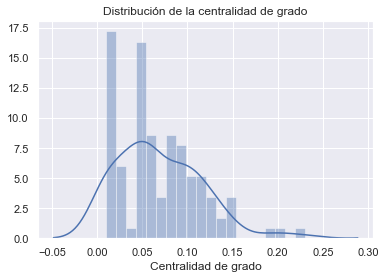

In [41]:
sns.distplot(deg_centr, bins = 20, norm_hist = True)
plt.title('Distribución de la centralidad de grado')
plt.xlabel('Centralidad de grado');

In [30]:
deg_centr.describe()

count    105.000000
mean       0.068681
std        0.046314
min        0.009615
25%        0.028846
50%        0.057692
75%        0.096154
max        0.230769
Name: deg-centrality, dtype: float64

Se observa que la mayoría de los datos poseen centralidades bastante bajas (de la orden de $10^{-2}$) y únicamente unos cuantos Pokemon aparecen en una fracción considerable de los equipos. Aun así, incluso la centralidad máxima es de apenas 0.23, lo que habla de un metajuego que, a pesar de que unos cuantos Pokemon tienen un uso desproporcionadamente alto, de todos modos no posee ninguna estrategia que domine al punto de ser la única que hay.

Ahora se verá cómo se relaciona la centralidad de grado con el porcentaje de uso.

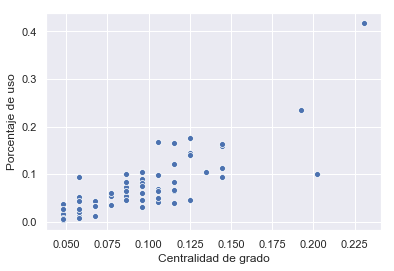

In [40]:
sns.scatterplot(deg_centr, df['usage'])
plt.xlabel('Centralidad de grado')
plt.ylabel('Porcentaje de uso');

In [32]:
df[['deg-centrality', 'usage']].corr()

,deg-centrality,usage
deg-centrality,1.000000,0.829585
usage,0.829585,1.000000


Como es de esperarse, la centralidad de grado está altamente correlacionada con el porcentaje de uso, aunque no son la misma cantidad, ya que la centralidad de grado establece qué tan versátil es un Pokemon en el sentido de que puede aparecer en una gran cantidad de equipos y funcionar bien en todos, mientras que el uso es simplemente cuánto se usa. Sin embargo, el que estén correlacionados sí da un insight importante: el metajuego valora la versatilidad.

### Centralidad de eigenvector

Se calculará ahora la centralidad de eigenvector. Nuevamente, como casi todos los nodos tienen grado base de 5, las direcciones de los enlaces no importan. La centralidad de eigenvector es una medida de qué tan "importante" es un Pokemon en el metajuego en el sentido de que una centralidad de eigenvector grande implica que suele aparecer con Pokemon de centralidad alta, por lo que se puede decir que tiene una gran "sinergía" con los Pokemon más comunes. Dicho de otra manera, un Pokemon con centralidad de eigenvector alta será parte de las estrategias más comunes de los Pokemon más "importantes".

In [33]:
df['eigenvec-centr'] =  pd.Series(nx.eigenvector_centrality_numpy(G))

In [34]:
eigenvec_centr = df['eigenvec-centr'].sort_values(ascending = False)

In [35]:
eigenvec_centr.head(10)

name
Greninja-Ash        0.424814
Tornadus-Therian    0.401132
Ferrothorn          0.398206
Swampert-Mega       0.396828
Pelipper            0.396828
Manaphy             0.324868
Medicham-Mega       0.143582
Landorus-Therian    0.137041
Tapu Koko           0.085600
Magearna            0.085384
Name: eigenvec-centr, dtype: float64

In [36]:
eigenvec_centr.describe()

count    1.050000e+02
mean     3.417259e-02
std      9.184982e-02
min     -1.902370e-17
25%      9.895382e-18
50%      2.232571e-03
75%      1.637550e-02
max      4.248139e-01
Name: eigenvec-centr, dtype: float64

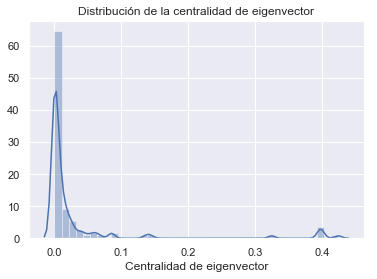

In [42]:
sns.distplot(eigenvec_centr, bins = 40)
plt.title('Distribución de la centralidad de eigenvector')
plt.xlabel('Centralidad de eigenvector');

Se observa que la centralidad de eigenvector suele tomar valores pequeños, y su distribución está mucho más sesgada a la derecha que la de la centralidad de grado. Curiosamente, los Pokemon con centralidad de eigenvector más alta suelen encontrarse en equipos que utilizan la mecánica de lluvia, indicando que dicha estrategia es bastante dominante incluso en este metajuego (digo incluso ya que la lluvia se nerfeó de manera considerable entre las generaciones cinco y seis, siendo el clima, y en especial la lluvia, en esta primera la mecánica más importante del metajuego).

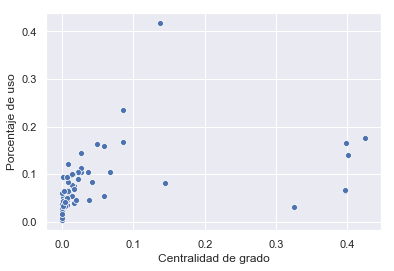

In [43]:
sns.scatterplot(df['eigenvec-centr'], df['usage'])
plt.xlabel('Centralidad de grado')
plt.ylabel('Porcentaje de uso');

In [44]:
df[['eigenvec-centr', 'usage']].corr('pearson')

,eigenvec-centr,usage
eigenvec-centr,1.000000,0.382159
usage,0.382159,1.000000


In [45]:
df[['eigenvec-centr', 'usage']].corr('spearman')

,eigenvec-centr,usage
eigenvec-centr,1.000000,0.809246
usage,0.809246,1.000000


In [50]:
df[(df['usage'] > 0.1) & (df['usage'] < 0.2) & (df['eigenvec-centr'] > 0.3)].index #Los Pokemon de hasta la derecha
#en el scatterplot con uso alto

Index(['Ferrothorn', 'Greninja-Ash', 'Tornadus-Therian'], dtype='object', name='name')

In [46]:
G['Tornadus-Therian']

AtlasView({'Swampert-Mega': {}, 'Pelipper': {}, 'Ferrothorn': {}, 'Greninja-Ash': {}, 'Manaphy': {}})

In [47]:
G['Greninja-Ash']

AtlasView({'Ferrothorn': {}, 'Pelipper': {}, 'Swampert-Mega': {}, 'Tornadus-Therian': {}, 'Medicham-Mega': {}})

In [48]:
G['Ferrothorn']

AtlasView({'Pelipper': {}, 'Swampert-Mega': {}, 'Greninja-Ash': {}, 'Tornadus-Therian': {}, 'Manaphy': {}})

Se observa que la centralidad de eigenvector está correlacionada con el porcentaje de uso pero no de manera lineal. En general se observan dos grupos, aquellos con centralidad $\leq$ ~ $0.1$, que tienen una relación creciente con el uso, y aquellos con centralidad mayor, que no parecen seguir un comportamiento específico. Los Pokemon con centralidad alta y uso bajo son aquellos que en realidad solo funcionan en la lluvia (Pelipper, Mega Swampert y Manaphy), y su valor de centralidad se debe a que son parte de la estrategia más común de Pokemon más comunes (Ash-Greninja, Ferrothorn y Tornadus-Therian).

## Estructura de moño

A continuación se verán las componentes fuertemente conectadas. Una CFC es una componente de la red dirigida donde existen caminos de ambos sentidos entre dos nodos, i.e. es posible llegar del nodo i al j y de regreso.

In [51]:
#Se le agrega al dataframe df una columna que tome el valor de cero
#si el Pokemon no aparece en la componente conectada y uno si sí

for comp in nx.strongly_connected_components(G):
    comp = tuple(comp)
    if len(comp) == 1:
        poke = comp[0]
        #print(poke, df.loc[poke,['in-degree','out-degree']])
        df.loc[poke,'in-connected-comp'] = 0

In [52]:
df['in-connected-comp'].fillna(1, inplace = True) #A los que estaban en la componente no se les pudo 
# asignar un valor directamente

Primero se checará lo obvio: que en efecto los Pokemon con grado de entrada o salida cero no estén en la componente conectada.

In [53]:
grados_cero = (df['in-degree'] == 0) | (df['out-degree'] == 0)

df[grados_cero]['in-connected-comp'].unique()

array([0.])

Ahora se verá cuáles Pokemon con grados distintos a cero no están en la componente.

In [54]:
grados_no_cero = (df['in-degree'] != 0) & (df['out-degree'] != 0)

gnc_en_comp = df[grados_no_cero]['in-connected-comp']
gnc_en_comp[gnc_en_comp == 0]

name
Tyranitar-Mega       0.0
Breloom              0.0
Thundurus-Therian    0.0
Thundurus            0.0
Name: in-connected-comp, dtype: float64

Se tienen entonces los siguientes cuatro grupos:

In [55]:
lado_izq = df[df['in-degree'] == 0].index #Lado izquierdo del moño
centro = df[df['in-connected-comp'] == 1].index #Centro del moño; componente conectada
lado_der = df[df['out-degree'] == 0].index #Lado derecho del moño
atipicos = gnc_en_comp[gnc_en_comp == 0].index #Atípicos; no se encuentran ni en el centro ni en los lados

Se observa entonces una estructura de moño. Estas estructuras se componen de tres partes: un conjunto que solo tiene enlaces de salida, un conjunto conectado (fuertemente), y uno que solo tiene enlaces de entrada. La estructura se muestra en la siguiente imagen:

<img src = 'General_bowtie_architecture.png' width = '500' height = '250'>

Aquellos Pokemon en el lado izquierdo sobreviven en el metajuego pero no son centrales a la estrategia de ningún otro Pokemon. Los del lado derecho son aquellos que por sí solos no sobreviven, pero que son centrales a alguna estrategia (esto ya se había comentado en el contexto de los grados de entrada y de salida cero). Los del centro son los más interesantes: en biología se considera a la parte central de una estructura como esta como el conjunto de criaturas que podrían formar un ecosistema autosustentable. Asimismo aquí la componente central se puede ver como aquel conjunto de Pokemon con estrategias que se contraatacan entre ellas, formando un metajuego estable por sí solos, aunque sí cabe mencionar que un análisis de este tipo sería más conclusivo si la red fuera de qué Pokemon se contraatacan y no de cuáles forman equipos entre ellos.

Finalmente, se verá cómo se relaciona el estar en la CFC con el uso.

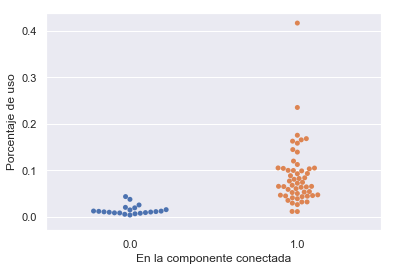

In [57]:
sns.swarmplot(df['in-connected-comp'], df['usage'])
plt.xlabel('En la componente conectada')
plt.ylabel('Porcentaje de uso');

In [55]:
df[['in-connected-comp', 'usage']].corr()

,in-connected-comp,usage
in-connected-comp,1.000000,0.511857
usage,0.511857,1.000000


In [56]:
df[['in-connected-comp', 'usage']].corr('spearman')

,in-connected-comp,usage
in-connected-comp,1.000000,0.732492
usage,0.732492,1.000000


Entonces ser parte de la CFC sí implica ser utilizado con mayor frecuencia.